# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:10<00:00, 1247.67it/s]


In [23]:
preprocessed_reviews[15]

'ineffective worthless bought product indoors two outdoor fly traps outdoor traps worked immediately noticed less flies home backdoor past week however indoor trap caught zero flies yet one week outdoor traps caught combined get excited looking trap thinking fly caught realize picture fly instead not waste money product'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [132]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [146]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_test.append(sentance.split())
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [24]:
final['clean_text']=preprocessed_reviews

In [25]:
final['clean_text'].head(5)

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
Name: clean_text, dtype: object

In [26]:
final=final.sort_values('Time',ascending=True)

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [28]:
%%time
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)# y_train
final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_train))
print("the shape of out text BOW vectorizer ",final_counts_x_train.get_shape())
print("the number of unique words ", final_counts_x_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (52663, 49074)
the number of unique words  49074
Wall time: 12.4 s


In [88]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l1',C=i)
    log_reg.fit(final_counts_x_train, y_tr)
    
    
    pred_tr = log_reg.predict_proba(final_counts_x_train)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(final_counts_x_crossval)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.5
AUC score on crossval datafor C value 1e-05 is  0.5
AUC score on train data for C value 0.0001 is  0.5
AUC score on crossval datafor C value 0.0001 is  0.5
AUC score on train data for C value 0.001 is  0.7092666446969244
AUC score on crossval datafor C value 0.001 is  0.7239324371018906
AUC score on train data for C value 0.01 is  0.8746052055448057
AUC score on crossval datafor C value 0.01 is  0.8756752886995094
AUC score on train data for C value 0.1 is  0.9443779806233573
AUC score on crossval datafor C value 0.1 is  0.9354546065010894
AUC score on train data for C value 10 is  0.9993441724839726
AUC score on crossval datafor C value 10 is  0.9054866063314443
AUC score on train data for C value 100 is  0.9999481701116869
AUC score on crossval datafor C value 100 is  0.8768990632580236


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 1000 is  0.9999968776166709
AUC score on crossval datafor C value 1000 is  0.8508169753574498


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 10000 is  0.9999976480930222
AUC score on crossval datafor C value 10000 is  0.824006277559522
Wall time: 43min 10s


In [89]:
print(auc_score_tr)

[0.5, 0.5, 0.7092666446969244, 0.8746052055448057, 0.9443779806233573, 0.9993441724839726, 0.9999481701116869, 0.9999968776166709, 0.9999976480930222]


In [90]:
print(auc_score_cv)

[0.5, 0.5, 0.7239324371018906, 0.8756752886995094, 0.9354546065010894, 0.9054866063314443, 0.8768990632580236, 0.8508169753574498, 0.824006277559522]


Text(0.5,1,'C values v/s AUC')

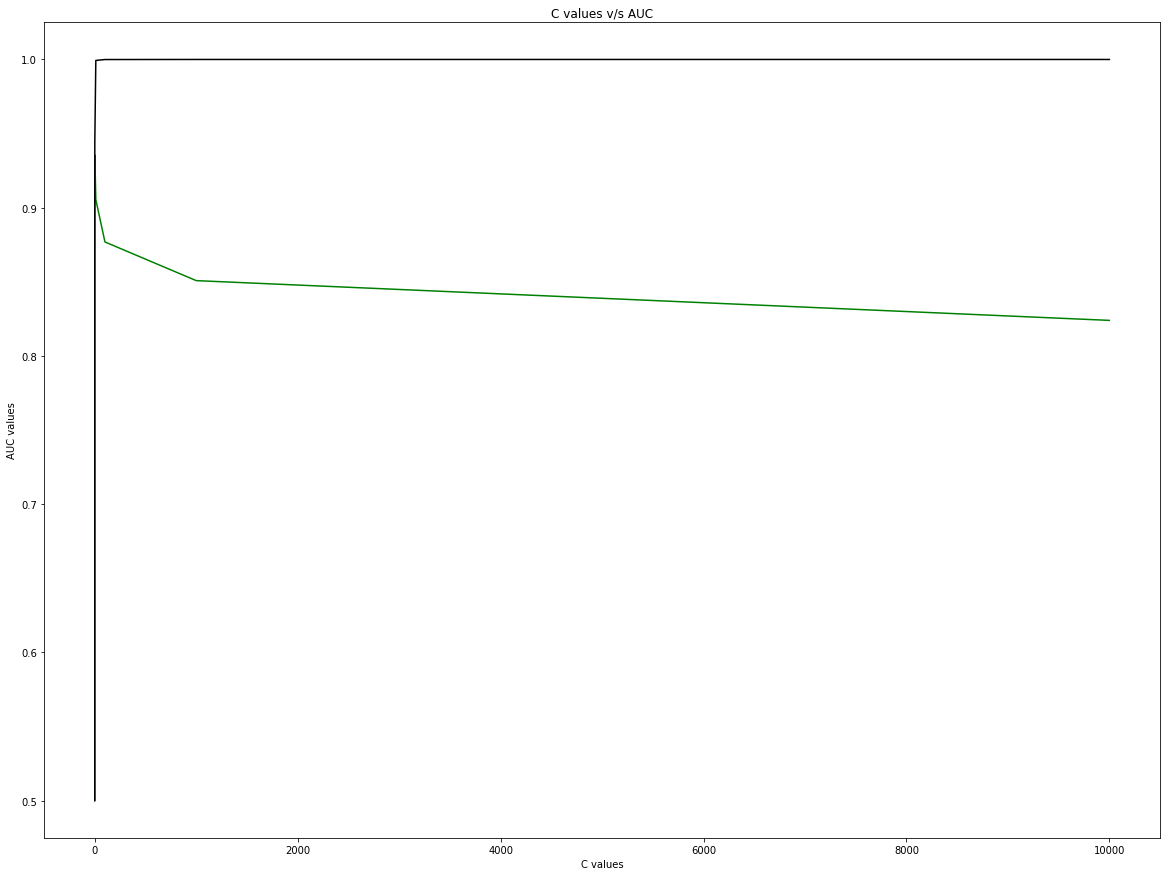

In [91]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='green')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [195]:
# Please write all the code with proper documentation
log_reg_sparse= LogisticRegression(penalty='l1',C=100)
log_reg_sparse= log_reg_sparse.fit(final_counts_x_train, y_tr)
predict=log_reg_sparse.predict(final_counts_x_train)

In [196]:
#Reference:https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix
sparse_coefficients=log_reg_sparse.coef_
#flatten=sparse_coefficients.ravel()
non_zero=np.count_nonzero(sparse_coefficients)
total_val=np.product(sparse_coefficients.shape)
sparsity=(total_val-non_zero)*100/(total_val)
print("percentage of sparsity is",sparsity)

percentage of sparsity is 80.60683865183192


In [197]:
log_reg_sparse= LogisticRegression(penalty='l1',C=0.01)
log_reg_sparse= log_reg_sparse.fit(final_counts_x_train, y_tr)
predict=log_reg_sparse.predict(final_counts_x_train)

In [198]:
#Reference:https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix
sparse_coefficients=log_reg_sparse.coef_
#flatten=sparse_coefficients.ravel()
non_zero=np.count_nonzero(sparse_coefficients)
total_val=np.product(sparse_coefficients.shape)
sparsity=(total_val-non_zero)*100/(total_val)
print("percentage of sparsity is",sparsity)

percentage of sparsity is 99.79215062966132


In [199]:
log_reg_sparse= LogisticRegression(penalty='l1',C=1)
log_reg_sparse= log_reg_sparse.fit(final_counts_x_train, y_tr)
predict=log_reg_sparse.predict(final_counts_x_train)

In [200]:
#Reference:https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix
sparse_coefficients=log_reg_sparse.coef_
#flatten=sparse_coefficients.ravel()
non_zero=np.count_nonzero(sparse_coefficients)
total_val=np.product(sparse_coefficients.shape)
sparsity=(total_val-non_zero)*100/(total_val)
print("percentage of sparsity is",sparsity)

percentage of sparsity is 91.56987406773445


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [33]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l2',C=i)
    log_reg.fit(final_counts_x_train, y_tr)
    
    
    pred_tr = log_reg.predict_proba(final_counts_x_train)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(final_counts_x_crossval)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.4719210571605518
AUC score on crossval datafor C value 1e-05 is  0.4729424094858524
AUC score on train data for C value 0.0001 is  0.7193170829821176
AUC score on crossval datafor C value 0.0001 is  0.7258285856617193
AUC score on train data for C value 0.001 is  0.8998695619827984
AUC score on crossval datafor C value 0.001 is  0.8939359860297923
AUC score on train data for C value 0.01 is  0.9463701937873644
AUC score on crossval datafor C value 0.01 is  0.931494862394566
AUC score on train data for C value 0.1 is  0.9748684027787955
AUC score on crossval datafor C value 0.1 is  0.9419449982550602


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 10 is  0.9963609271342928
AUC score on crossval datafor C value 10 is  0.9261505019552075


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 100 is  0.9953304568882889
AUC score on crossval datafor C value 100 is  0.9279558476991857


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 1000 is  0.9952905177391711
AUC score on crossval datafor C value 1000 is  0.9280324056684058


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AUC score on train data for C value 10000 is  0.995856178585252
AUC score on crossval datafor C value 10000 is  0.9267771997803751
Wall time: 50.7 s


In [34]:
print(auc_score_tr)

[0.4719210571605518, 0.7193170829821176, 0.8998695619827984, 0.9463701937873644, 0.9748684027787955, 0.9963609271342928, 0.9953304568882889, 0.9952905177391711, 0.995856178585252]


In [35]:
print(auc_score_cv)

[0.4729424094858524, 0.7258285856617193, 0.8939359860297923, 0.931494862394566, 0.9419449982550602, 0.9261505019552075, 0.9279558476991857, 0.9280324056684058, 0.9267771997803751]


Text(0.5,1,'C values v/s AUC')

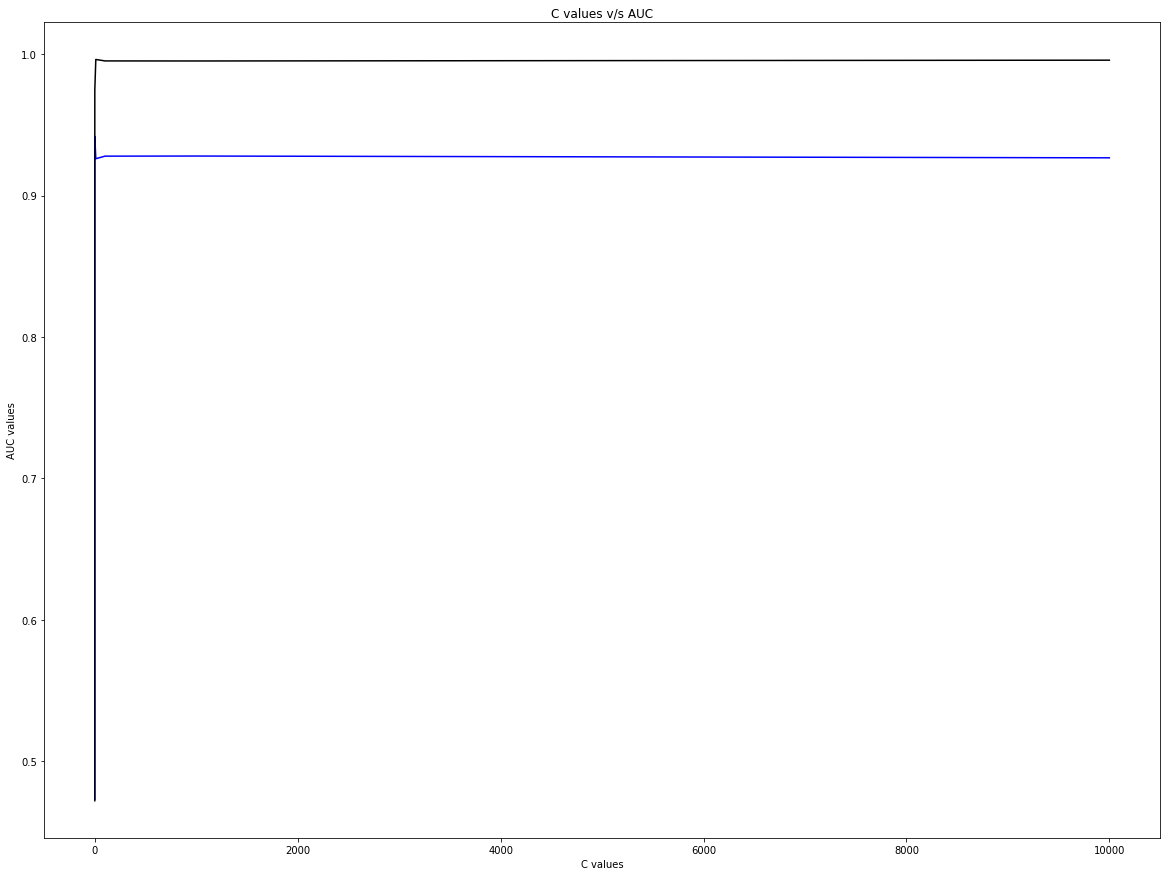

In [36]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='blue')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

In [37]:
best_c=1000

In [38]:
log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg.fit(final_counts_x_train, y_tr)
prediction = log_reg.predict_proba(final_counts_x_test)[:,1]

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [39]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.9232792010402056


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


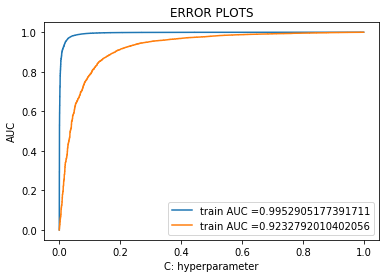

Train confusion matrix
[[ 7265   760]
 [  264 44374]]
Test confusion matrix
[[ 1989   925]
 [  638 14003]]


In [40]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg_train=log_reg.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, log_reg.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, log_reg.predict(final_counts_x_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,log_reg.predict(final_counts_x_test))
print(confusion_matrix(y_test, log_reg.predict(final_counts_x_test)))


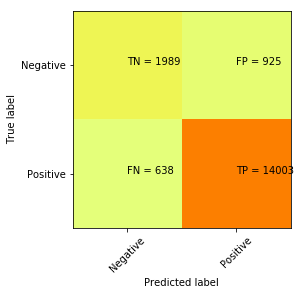

In [41]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [43]:
from scipy.sparse import find

In [44]:

#Weights before adding random noise
weights_before_pertubation= log_reg_train.coef_
print(weights_before_pertubation[:50])

[[-9.56321911e-01  1.03494269e+00  3.25892962e-02 ... -1.51060590e-01
   6.33736818e-04  1.22970788e-01]]


In [45]:
#https://github.com/numpy/numpy/issues/7225
#np.add(final_counts_x_train_copy.data, e, out=final_counts_x_train_copy.data, casting="unsafe")

In [46]:
#correct
import copy
final_counts_x_train_copy=copy.deepcopy(final_counts_x_train) 
final_counts_x_train_copy=final_counts_x_train_copy.astype(np.int64)
e=np.random.uniform(0,0.1)
print(e)
final_counts_x_train_copy.data=final_counts_x_train_copy.data+e
#final_counts_x_train_copy.data+=e
pertubated_model = LogisticRegression(penalty='l2',C= 1000)
pertubated_model.fit(final_counts_x_train_copy, y_tr)

0.045479994852233196


C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
#correct
from scipy.sparse import find
#Weights after adding random noise
weights_after_pertubation= pertubated_model.coef_
print(weights_after_pertubation[:50])

[[-1.00418209e+00  1.09979893e+00  3.41396889e-02 ... -1.54660486e-01
   6.11843872e-04  1.29399729e-01]]


In [48]:
type(weights_after_pertubation)

numpy.ndarray

In [49]:
np.array_equal(weights_before_pertubation,weights_after_pertubation)

False

This shows that the weights are  changing after pertubation and hence there are features that are multi-collinear

In [50]:
print(weights_before_pertubation.size)

49074


In [51]:
print(weights_after_pertubation.size)

49074


In [52]:
weights_diff = abs((weights_before_pertubation - weights_after_pertubation)/weights_before_pertubation) * 100

In [53]:
type(weights_diff)

numpy.ndarray

In [54]:
a=range(0,101,5)
for i in a:
    percentile=np.nanpercentile(weights_diff,i)
    print(str(i) + "th %ile is "+str(percentile))

0th %ile is 0.00016425275268041337
5th %ile is 0.39786207820950137
10th %ile is 0.7999751275506208
15th %ile is 1.1840089547284989
20th %ile is 1.571884067338071
25th %ile is 1.9486854292241527
30th %ile is 2.3526116497720224
35th %ile is 2.7708516537868926
40th %ile is 3.186558558966761
45th %ile is 3.6024870573584913
50th %ile is 4.0168594362832115
55th %ile is 4.476348570570469
60th %ile is 4.975871944751071
65th %ile is 5.564796904827831
70th %ile is 6.292531201224918
75th %ile is 7.144008979293083
80th %ile is 8.359536170707141
85th %ile is 10.153043196046749
90th %ile is 13.412883363785804
95th %ile is 24.256528403260532
100th %ile is 32855.22446143028


In [55]:
b=range(90,101,1)
for i in a:
    percentile=np.nanpercentile(weights_diff,i)
    print(str(i) + "th %ile is "+str(percentile))

0th %ile is 0.00016425275268041337
5th %ile is 0.39786207820950137
10th %ile is 0.7999751275506208
15th %ile is 1.1840089547284989
20th %ile is 1.571884067338071
25th %ile is 1.9486854292241527
30th %ile is 2.3526116497720224
35th %ile is 2.7708516537868926
40th %ile is 3.186558558966761
45th %ile is 3.6024870573584913
50th %ile is 4.0168594362832115
55th %ile is 4.476348570570469
60th %ile is 4.975871944751071
65th %ile is 5.564796904827831
70th %ile is 6.292531201224918
75th %ile is 7.144008979293083
80th %ile is 8.359536170707141
85th %ile is 10.153043196046749
90th %ile is 13.412883363785804
95th %ile is 24.256528403260532
100th %ile is 32855.22446143028


In [56]:
a=[97,98,98.5,99,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,99.95,99.96,99.97,99.98,99.99,99.995,100]

for i in a:
    percentile=np.nanpercentile(weights_diff,i)
    print(str(i) + "th %ile is "+str(percentile))

97th %ile is 41.82449852873119
98th %ile is 66.09493445924227
98.5th %ile is 95.58583222873135
99th %ile is 175.20728374336224
99.1th %ile is 175.20728374336224
99.2th %ile is 190.6098261788688
99.3th %ile is 194.128971045959
99.4th %ile is 218.2943488748545
99.5th %ile is 258.0512010038456
99.6th %ile is 288.71089133315064
99.7th %ile is 409.6908317159009
99.8th %ile is 631.2456421207235
99.9th %ile is 1587.7083342710807
99.95th %ile is 1888.3007452202005
99.96th %ile is 2905.7699644042996
99.97th %ile is 3993.9879791450535
99.98th %ile is 5337.091627678158
99.99th %ile is 13172.994372482468
99.995th %ile is 17245.190527785035
100th %ile is 32855.22446143028


In [87]:


top_features=[]
for i in np.where(weights_diff > np.nanpercentile(weights_diff,99.9))[1]:
    top_features.append(count_vect.get_feature_names()[i])
print("no of features above 99.9 percentile are")
print(len(top_features))
print(top_features[-10:])



no of features above 99.9 percentile are
43
['skincare', 'slice', 'stength', 'stiffen', 'strengthening', 'tangyness', 'tonic', 'torch', 'transform', 'underscores']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [224]:
#Reference:https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/4%20Amazon%20Food%20Reviews%20-%20Logistic%20Regression.ipynb
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        

In [225]:
show_most_informative_features(count_vect,log_reg_train)

			Negative						Positive
________________________________________________________________________________________________
	-4.0028	worst          				3.4108	addictive      
	-3.8261	cancelled      				3.2027	pleasantly     
	-3.3304	flavorless     				3.0573	worried        
	-3.3132	died           				3.0460	beat           
	-3.1191	undrinkable    				2.9964	compares       
	-3.1121	rip            				2.9283	skeptical      
	-3.1065	awful          				2.8802	worry          
	-3.0756	disappointment 				2.7246	holds          
	-2.9442	tasteless      				2.6624	hearty         
	-2.9304	terrible       				2.6571	drawback       


#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [74]:
# Please write all the code with proper documentation

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [75]:
# Please write all the code with proper documentation

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [226]:
%%time
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)

some sample features(unique words in the corpus) ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almonds']
Wall time: 7.09 s


In [227]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l1',C=i)
    log_reg.fit(final_tf_idf_tr, y_tr)
    
    
    pred_tr = log_reg.predict_proba(final_tf_idf_tr )[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(final_tf_idf_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.5
AUC score on crossval datafor C value 1e-05 is  0.5
AUC score on train data for C value 0.0001 is  0.5
AUC score on crossval datafor C value 0.0001 is  0.5
AUC score on train data for C value 0.001 is  0.5
AUC score on crossval datafor C value 0.001 is  0.5
AUC score on train data for C value 0.01 is  0.727072953362871
AUC score on crossval datafor C value 0.01 is  0.7341576509286757
AUC score on train data for C value 0.1 is  0.8967816770115679
AUC score on crossval datafor C value 0.1 is  0.8957367092025112
AUC score on train data for C value 10 is  0.9145537706652017
AUC score on crossval datafor C value 10 is  0.9091951799576689
AUC score on train data for C value 100 is  0.9145505324312617
AUC score on crossval datafor C value 100 is  0.9091188482681606
AUC score on train data for C value 1000 is  0.9145506022207865
AUC score on crossval datafor C value 1000 is  0.9091110901066071
AUC score on train data for C value 10000 is  0.914

Text(0.5,1,'C values v/s AUC')

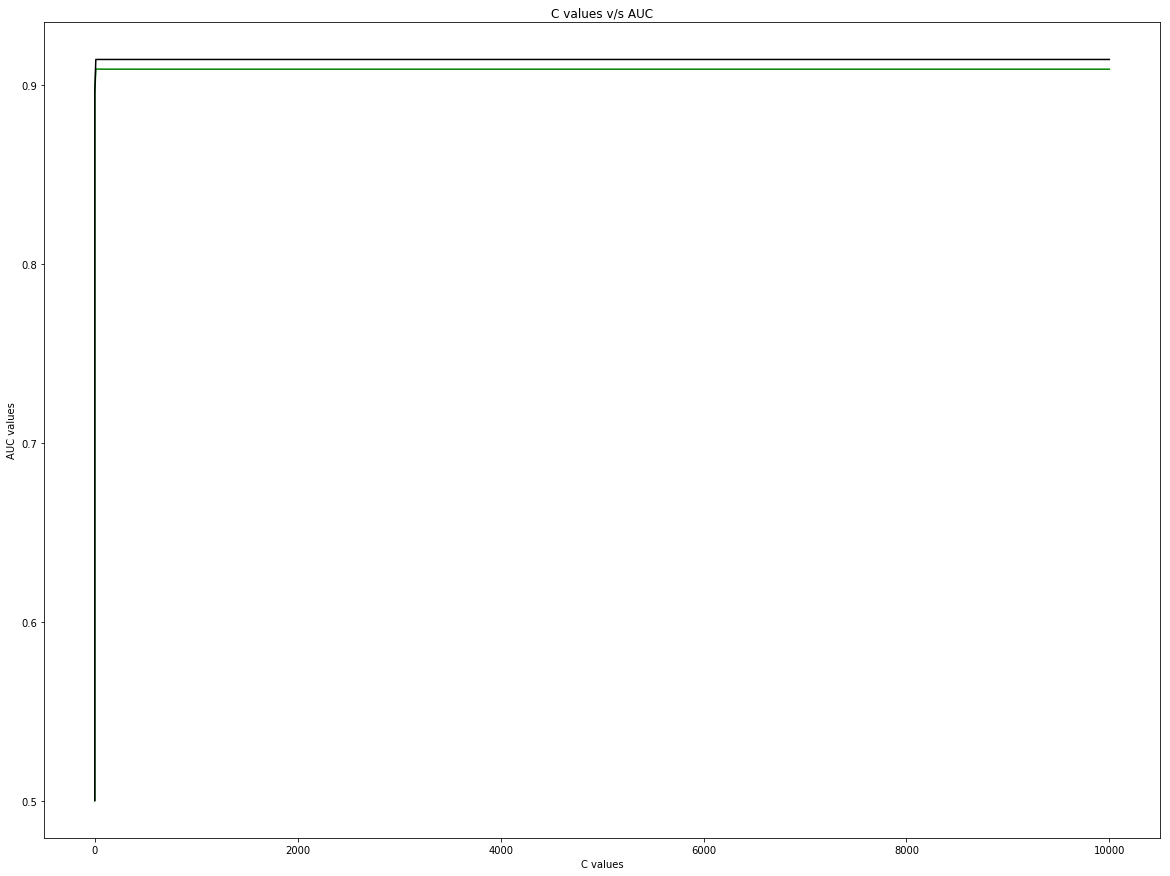

In [228]:
# Please write all the code with proper documentation
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='green')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [229]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l2',C=i)
    log_reg.fit(final_tf_idf_tr, y_tr)
    
    
    pred_tr = log_reg.predict_proba(final_tf_idf_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(final_tf_idf_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]

AUC score on train data for C value 1e-05 is  0.5695007829686761
AUC score on crossval datafor C value 1e-05 is  0.57525918832476
AUC score on train data for C value 0.0001 is  0.6766512110785566
AUC score on crossval datafor C value 0.0001 is  0.6799302136127892
AUC score on train data for C value 0.001 is  0.8762055770484029
AUC score on crossval datafor C value 0.001 is  0.8731834965111763
AUC score on train data for C value 0.01 is  0.8820271121136609
AUC score on crossval datafor C value 0.01 is  0.8774164141061824
AUC score on train data for C value 0.1 is  0.9060586268296894
AUC score on crossval datafor C value 0.1 is  0.9009111659038453
AUC score on train data for C value 10 is  0.9145569419011977
AUC score on crossval datafor C value 10 is  0.909102642330693
AUC score on train data for C value 100 is  0.9145503146879452
AUC score on crossval datafor C value 100 is  0.909103461247746
AUC score on train data for C value 1000 is  0.9145498736181499
AUC score on crossval datafor 

In [230]:
print(auc_score_tr)

[0.5695007829686761, 0.6766512110785566, 0.8762055770484029, 0.8820271121136609, 0.9060586268296894, 0.9145569419011977, 0.9145503146879452, 0.9145498736181499, 0.9145495442115941]


In [231]:
print(auc_score_cv)

[0.57525918832476, 0.6799302136127892, 0.8731834965111763, 0.8774164141061824, 0.9009111659038453, 0.909102642330693, 0.909103461247746, 0.9091033319450534, 0.909103375045951]


Text(0.5,1,'C values v/s AUC')

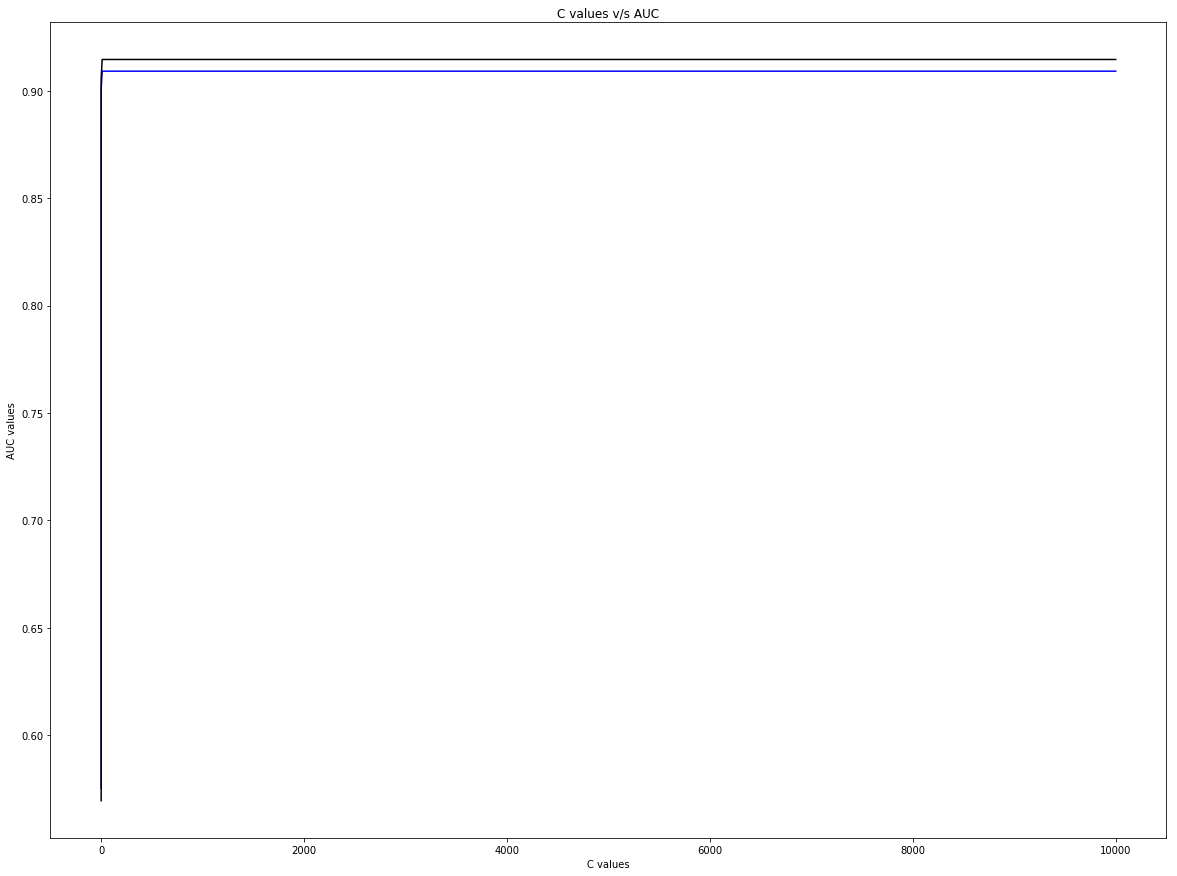

In [232]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='blue')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

In [234]:
best_c2=10

In [235]:
log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg.fit(final_tf_idf_tr, y_tr)
prediction = log_reg.predict_proba(final_tf_idf_test)[:,1]

In [236]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.9120693071613704


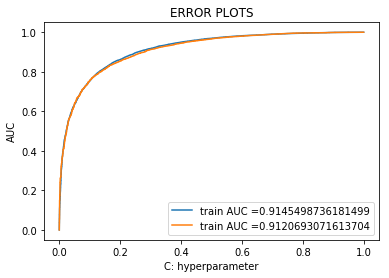

Train confusion matrix
[[ 4162  3863]
 [ 1486 43152]]
Test confusion matrix
[[ 1510  1404]
 [  541 14100]]


In [237]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg_train=log_reg.fit(final_tf_idf_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, log_reg.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, log_reg.predict(final_tf_idf_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,log_reg.predict(final_tf_idf_test))
print(confusion_matrix(y_test, log_reg.predict(final_tf_idf_test)))


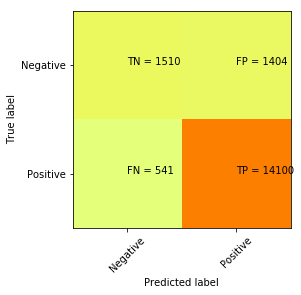

In [239]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [240]:
#Reference:https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/4%20Amazon%20Food%20Reviews%20-%20Logistic%20Regression.ipynb
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        

In [241]:
show_most_informative_features(tf_idf_vect,log_reg_train)

			Negative						Positive
________________________________________________________________________________________________
	-5.7959	not            				9.3522	delicious      
	-5.6270	disappointed   				9.1955	great          
	-5.1477	money          				8.4383	perfect        
	-4.5445	away           				7.5405	excellent      
	-3.8013	thought        				7.2168	best           
	-3.6046	bad            				7.0808	loves          
	-3.2902	maybe          				7.0222	amazing        
	-3.1584	opened         				6.8779	wonderful      
	-2.9244	even           				6.4952	smooth         
	-2.5577	old            				6.3024	pleased        


#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [78]:
# Please write all the code with proper documentation

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [79]:
# Please write all the code with proper documentation

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]

for sentance in x_tr:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [33]:
len(y_tr)

52663

In [34]:
len(y_tr)

52663

In [35]:
len(y_cv)

17555

In [36]:
len(y_test)

17555

In [37]:
len(x_tr)

52663

In [38]:
len(x_cv)

17555

In [39]:
len(x_test)

17555

In [40]:
import gensim
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
  

In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13806
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████████████████████████████████████████████| 52663/52663 [02:25<00:00, 360.85it/s]


52663
50


In [43]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:48<00:00, 360.72it/s]


17555
50


In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:52<00:00, 332.60it/s]


17555
50


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [282]:
%%time
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l1',C=i)
    log_reg.fit(sent_vectors_tr, y_tr)
    
    
    pred_tr = log_reg.predict_proba(sent_vectors_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.5
AUC score on crossval datafor C value 1e-05 is  0.5
AUC score on train data for C value 0.0001 is  0.6630849887059613
AUC score on crossval datafor C value 0.0001 is  0.6811178480687328
AUC score on train data for C value 0.001 is  0.8121118868449397
AUC score on crossval datafor C value 0.001 is  0.8246836620401732
AUC score on train data for C value 0.01 is  0.8953578143819181
AUC score on crossval datafor C value 0.01 is  0.8960658168807509
AUC score on train data for C value 0.1 is  0.8998496580103927
AUC score on crossval datafor C value 0.1 is  0.898792401208325
AUC score on train data for C value 10 is  0.8999905100204497
AUC score on crossval datafor C value 10 is  0.8987113284200896
AUC score on train data for C value 100 is  0.8999899461210914
AUC score on crossval datafor C value 100 is  0.8987089147698284
AUC score on train data for C value 1000 is  0.8999899126221195
AUC score on crossval datafor C value 1000 is  0.89870880

Text(0.5,1,'C values v/s AUC')

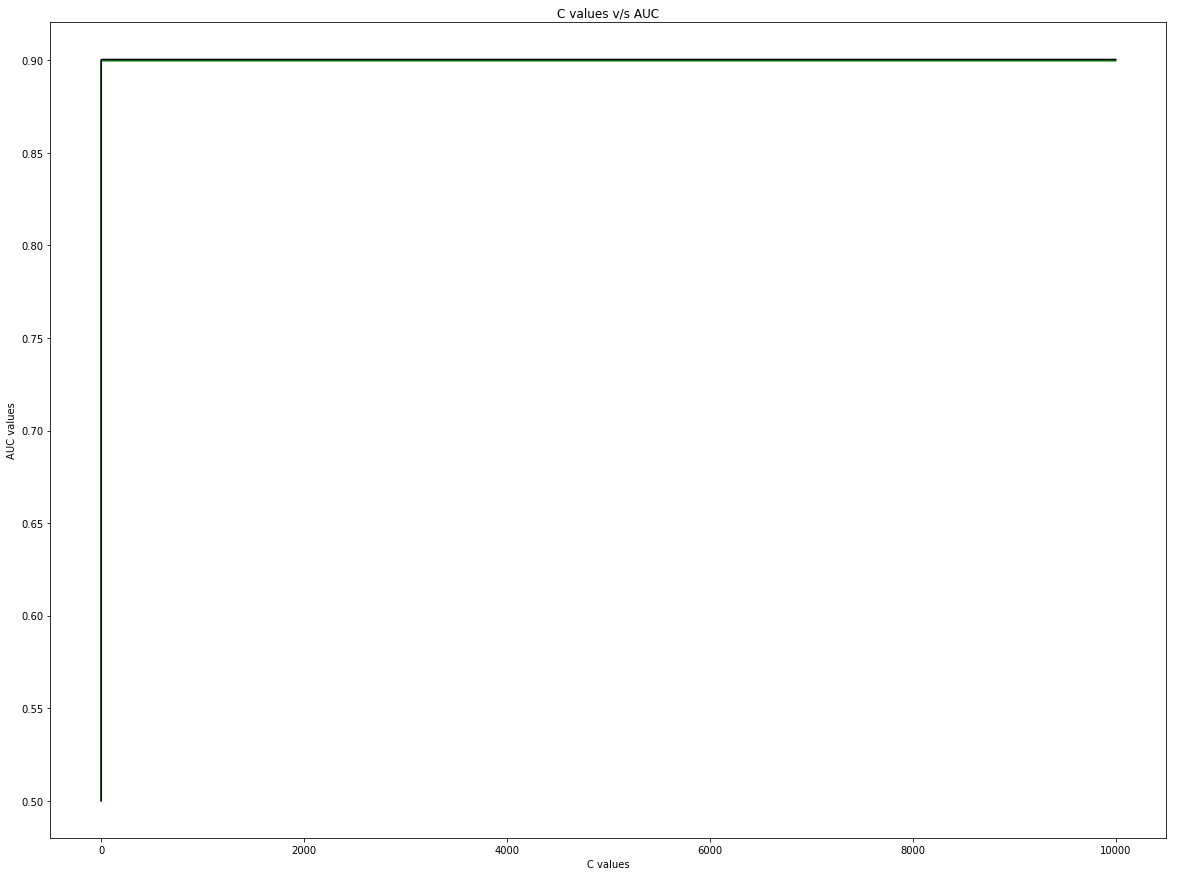

In [249]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='green')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [250]:
%%time
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000]

for i in a:

    log_reg = LogisticRegression(penalty='l2',C=i)
    log_reg.fit(sent_vectors_tr, y_tr)
    
    
    pred_tr = log_reg.predict_proba(sent_vectors_tr)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.6699685723812981
AUC score on crossval datafor C value 1e-05 is  0.6834399089226314
AUC score on train data for C value 0.0001 is  0.8244771501419729
AUC score on crossval datafor C value 0.0001 is  0.8337245494048995
AUC score on train data for C value 0.001 is  0.8929882004059237
AUC score on crossval datafor C value 0.001 is  0.8953404072250379
AUC score on train data for C value 0.01 is  0.8994739893744054
AUC score on crossval datafor C value 0.01 is  0.8995526579396831
AUC score on train data for C value 0.1 is  0.9004267615469211
AUC score on crossval datafor C value 0.1 is  0.8998253357678444
AUC score on train data for C value 10 is  0.9004519360242219
AUC score on crossval datafor C value 10 is  0.8997325395354836
AUC score on train data for C value 100 is  0.9004530917387488
AUC score on crossval datafor C value 100 is  0.8997318283706744
AUC score on train data for C value 1000 is  0.9004534462695336
AUC score on crossval data

Text(0.5,1,'C values v/s AUC')

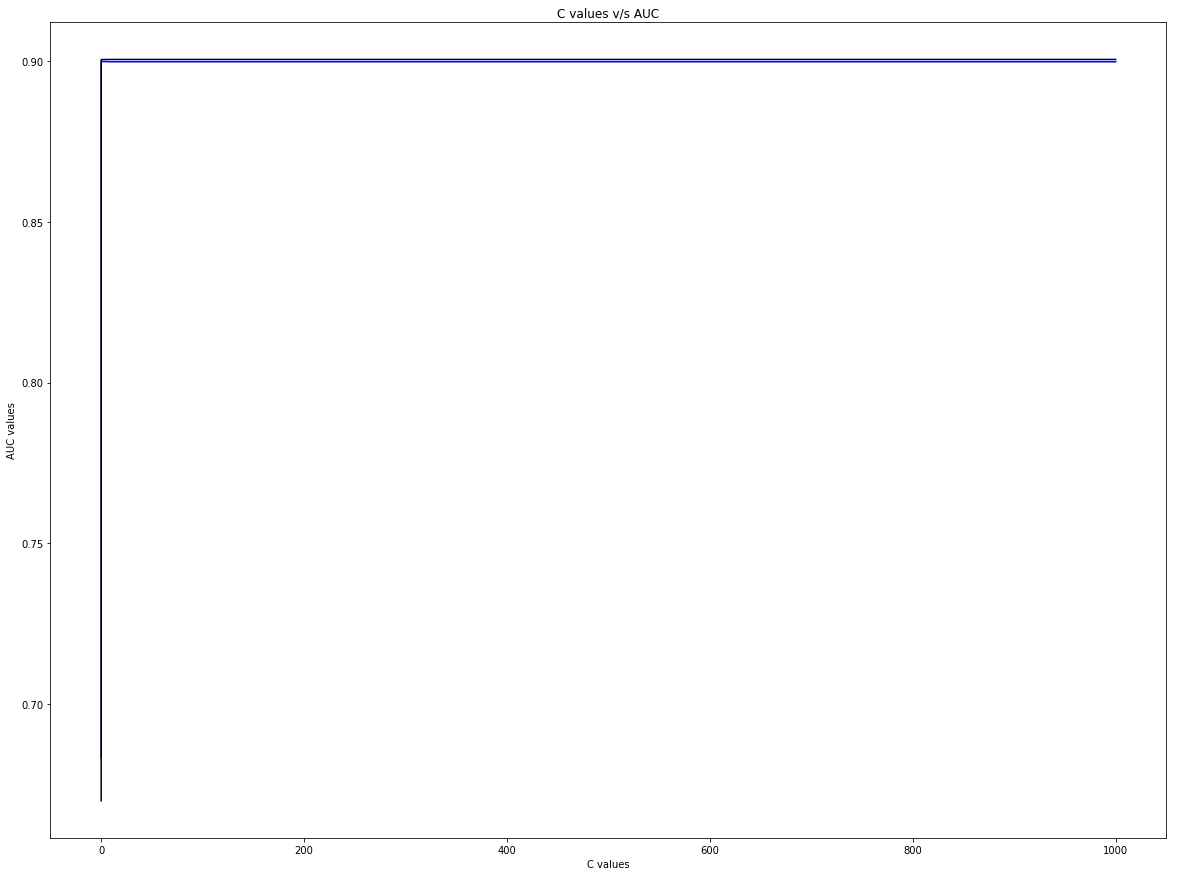

In [251]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='blue')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

In [283]:
best_c=100

In [284]:
log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg.fit(sent_vectors_tr, y_tr)
prediction = log_reg.predict_proba(sent_vectors_test)[:,1]

In [285]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.9036072532935007


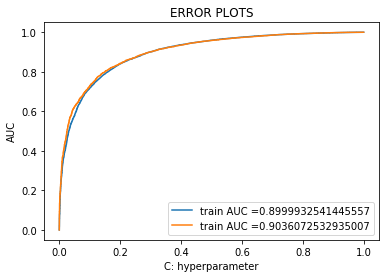

Train confusion matrix
[[ 3612  4413]
 [ 1432 43206]]
Test confusion matrix
[[ 1346  1568]
 [  519 14122]]


In [286]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg_train=log_reg.fit(sent_vectors_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, log_reg.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, log_reg.predict(sent_vectors_tr)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,log_reg.predict(sent_vectors_test))
print(confusion_matrix(y_test, log_reg.predict(sent_vectors_test)))


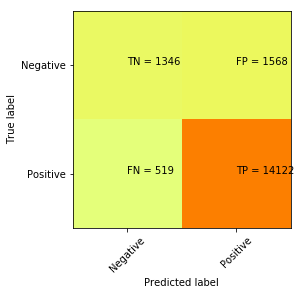

In [287]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 52663/52663 [27:17<00:00, 32.17it/s]


In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [09:28<00:00, 30.87it/s]


In [48]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [08:08<00:00, 35.96it/s]


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [51]:
%%time
#e all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l1',C=i)
    log_reg.fit(tfidf_sent_vectors_train, y_tr)
    
    
    pred_tr = log_reg.predict_proba(tfidf_sent_vectors_train)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba( tfidf_sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.5
AUC score on crossval datafor C value 1e-05 is  0.5
AUC score on train data for C value 0.0001 is  0.5
AUC score on crossval datafor C value 0.0001 is  0.5
AUC score on train data for C value 0.001 is  0.8128102119940557
AUC score on crossval datafor C value 0.001 is  0.8069443023910697
AUC score on train data for C value 0.01 is  0.8709940066152094
AUC score on crossval datafor C value 0.01 is  0.8692746222389511
AUC score on train data for C value 0.1 is  0.8767856829302779
AUC score on crossval datafor C value 0.1 is  0.8716630153741332
AUC score on train data for C value 10 is  0.8768150699032815
AUC score on crossval datafor C value 10 is  0.8715116881229401
AUC score on train data for C value 100 is  0.8768126775183794
AUC score on crossval datafor C value 100 is  0.871514554332625
AUC score on train data for C value 1000 is  0.8768118986672853
AUC score on crossval datafor C value 1000 is  0.8715166878270522
AUC score on train da

Text(0.5,1,'C values v/s AUC')

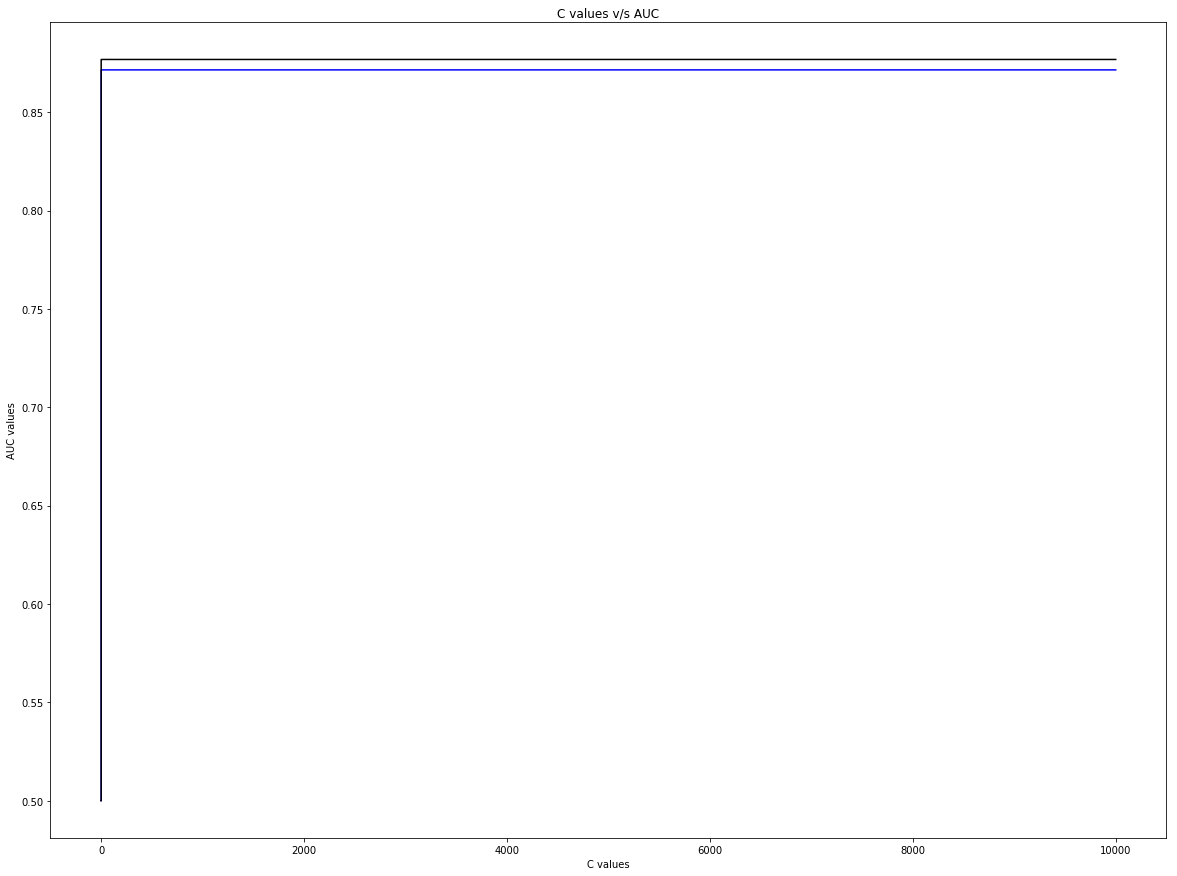

In [52]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='blue')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
%%time
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
auc_score_cv = []
a = [0.00001,0.0001,0.001,0.01,0.1,10,100,1000,10000]

for i in a:

    log_reg = LogisticRegression(penalty='l2',C=i)
    log_reg.fit(tfidf_sent_vectors_train, y_tr)
    
    
    pred_tr = log_reg.predict_proba(tfidf_sent_vectors_train)[:,1]
    auc_tr = roc_auc_score(y_tr, pred_tr)
    print("AUC score on train data for C value", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
    
    pred_cv = log_reg.predict_proba(tfidf_sent_vectors_cv)[:,1]
    auc_cv = roc_auc_score(y_cv, pred_cv)
    print("AUC score on crossval datafor C value", i, "is ", auc_cv)
    auc_score_cv.append(auc_cv)


auc_score_tr = [x for x in auc_score_tr]
auc_score_cv = [y for y in auc_score_cv]


AUC score on train data for C value 1e-05 is  0.6458804360282
AUC score on crossval datafor C value 1e-05 is  0.6603602187680876
AUC score on train data for C value 0.0001 is  0.7915843338708521
AUC score on crossval datafor C value 0.0001 is  0.7998940515287609
AUC score on train data for C value 0.001 is  0.8668214835605889
AUC score on crossval datafor C value 0.001 is  0.8650111892085006
AUC score on train data for C value 0.01 is  0.875235420305318
AUC score on crossval datafor C value 0.01 is  0.8707303119517971
AUC score on train data for C value 0.1 is  0.8767375114088426
AUC score on crossval datafor C value 0.1 is  0.8715703915453625
AUC score on train data for C value 10 is  0.8768117144229404
AUC score on crossval datafor C value 10 is  0.8715127009940318
AUC score on train data for C value 100 is  0.87681276405739
AUC score on crossval datafor C value 100 is  0.8715113217653111
AUC score on train data for C value 1000 is  0.8768126607688935
AUC score on crossval datafor C 

Text(0.5,1,'C values v/s AUC')

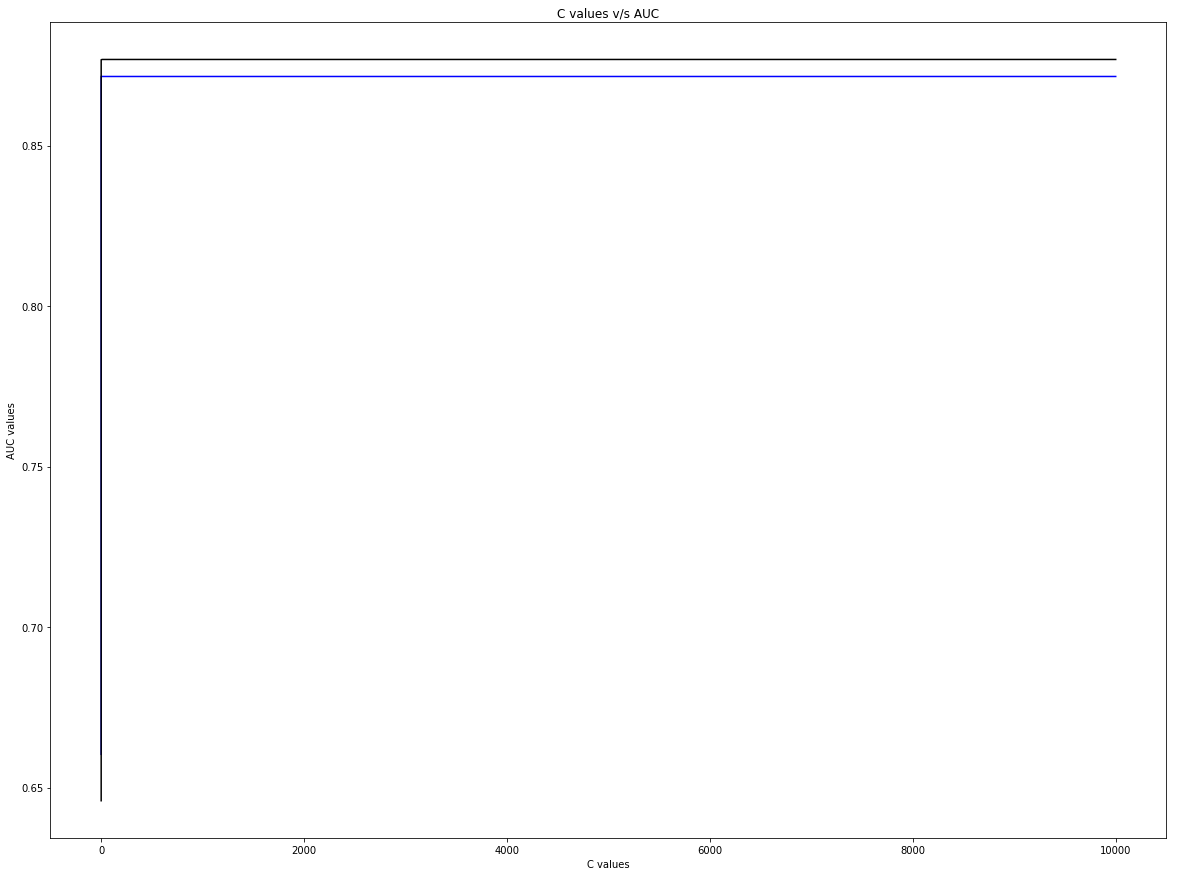

In [55]:
plt.figure(figsize = (20,15))
plt.plot(a, auc_score_cv,color='blue')




plt.plot(a, auc_score_tr,  color = 'black')


plt.xlabel("C values")
plt.ylabel("AUC values")
plt.title("C values v/s AUC")

In [56]:
best_c=10

In [58]:
log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg.fit(tfidf_sent_vectors_train, y_tr)
prediction = log_reg.predict_proba(tfidf_sent_vectors_test)[:,1]

In [59]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("auc score")
print(roc_auc_score(y_test,prediction))

auc score
0.8791530980051179


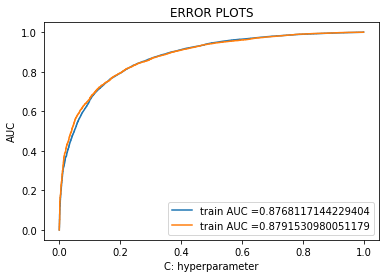

Train confusion matrix
[[ 2946  5079]
 [ 1346 43292]]
Test confusion matrix
[[ 1095  1819]
 [  519 14122]]


In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log_reg = LogisticRegression(penalty='l2',C=best_c)
log_reg_train=log_reg.fit(tfidf_sent_vectors_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, log_reg.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, log_reg.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
cm=confusion_matrix(y_test,log_reg.predict(tfidf_sent_vectors_test))
print(confusion_matrix(y_test, log_reg.predict(tfidf_sent_vectors_test)))


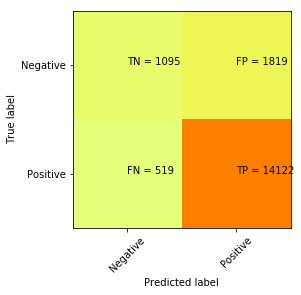

In [62]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


# [6] Conclusions

In [63]:
# Please compare all your models using Prettytable library
# reference from "http://zetcode.com/python/prettytable/"
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Vectorizer", "regularizer", "Hyper parameter", "AUC" ]
t.add_row(["BOW", "l1",100,0.8768 ])
t.add_row(["BOW", "l2", 1000,0.9237])
t.add_row(["TFIDF", "l1", 10,0.9011])
t.add_row(["TFIDF", "l2", 1000,0.912])
t.add_row(["W2V", "l1", 1000,0.8999])
t.add_row(["W2V", "l2", 100,0.9036])
t.add_row(["TFIDFW2V", "l1", 1000,0.8768])
t.add_row(["TFIDFW2V", "l2", 10,0.8791])
print(t)

+------------+-------------+-----------------+--------+
| Vectorizer | regularizer | Hyper parameter |  AUC   |
+------------+-------------+-----------------+--------+
|    BOW     |      l1     |       100       | 0.8768 |
|    BOW     |      l2     |       1000      | 0.9237 |
|   TFIDF    |      l1     |        10       | 0.9011 |
|   TFIDF    |      l2     |       1000      | 0.912  |
|    W2V     |      l1     |       1000      | 0.8999 |
|    W2V     |      l2     |       100       | 0.9036 |
|  TFIDFW2V  |      l1     |       1000      | 0.8768 |
|  TFIDFW2V  |      l2     |        10       | 0.8791 |
+------------+-------------+-----------------+--------+


The weights are changing before and after pertubation and thus there is  multicollinearity and we can obtain feature importance based on weights or coeffiencients of the obtained model cannot be use for obtaining insights